1. First we import all the relevant classes and libraries

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.autograd import grad
dtype = torch.float
device = torch.device("cpu")

2. Analytical solution is derived for validation

In [2]:
u_analytic = lambda x: -((x*x*x*x)/24)+((x*x*x)/12)-((x*x)/24)

3. PhysicsInformedBarModel Class written

In [14]:
class PhysicsInformedBarModel:
    """A class used for the definition of Physics Informed Models for one dimensional bars."""

    def __init__(self, E, I, L, u0, dist_load):
        """Construct a PhysicsInformedBar model"""

        self.E = E
        self.I = I
        self.L = L
        self.x = generate_grid_1d(L)
        self.u0 = u0
        self.dist_load = dist_load
        self.model = build_model(1,[60,60,60],1)
        self.differential_equation_loss_history = None
        self.boundary_condition_loss_history = None
        self.total_loss_history = None
        self.optimizer = None

    def get_displacements(self, x):
        """Get displacements."""

        u = self.model(x)   # predict

        return u

    def costFunction(self, x, u_pred):
        """Compute the cost function."""
        
        # Differential equation loss (f)
        st_diff =  get_derivative(u_pred, x, 1)
        nd_diff =  get_derivative(st_diff, x, 1)
        rd_diff = get_derivative(self.E(x)*self.I(x)*nd_diff, x, 1)
        th_diff =  get_derivative(rd_diff, x, 1)
        differential_equation_loss = th_diff + self.dist_load(x)
        differential_equation_loss = torch.sum(differential_equation_loss ** 2).view(1)
        
        # Boundary condition loss initialization
        boundary_condition_loss = 0

        # Sum over dirichlet boundary condition losses
        boundary_condition_loss += 10*(u_pred[0] - self.u0[0]) ** 2  #I HAVE MULTIPIED BY 10 TO GIVE MORE WEGHITAGE TO INITIAL CONDITION
        boundary_condition_loss += 10*(u_pred[-1] - self.u0[1]) ** 2
        boundary_condition_loss += (st_diff[0] - self.u0[2]) ** 2
        boundary_condition_loss += (st_diff[-1] - self.u0[3]) ** 2

        return differential_equation_loss, boundary_condition_loss

    def closure(self):
        """Calculation of training error and gradient"""
        self.optimizer.zero_grad()
        u_pred = self.get_displacements(self.x)
        loss = self.costFunction(self.x, u_pred)
        loss = loss[0] + loss[1]
        loss.backward(retain_graph=True)
        return loss

    def train(self, epochs, optimizer='Adam', **kwargs):
        """Train the model."""

        # Set optimizer
        if optimizer=='Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), **kwargs)
        
        elif optimizer=='LBFGS':
            self.optimizer = torch.optim.LBFGS(self.model.parameters(), **kwargs)

        # Initialize history arrays
        self.differential_equation_loss_history = np.zeros(epochs)
        self.boundary_condition_loss_history = np.zeros(epochs)
        self.total_loss_history = np.zeros(epochs)

        # Training loop
        for i in range(epochs):
            # Predict displacements
            u_pred = self.get_displacements(self.x)

            # Cost function calculation
            differential_equation_loss, boundary_condition_loss = self.costFunction(self.x, u_pred)

            # Total loss
            total_loss = differential_equation_loss + boundary_condition_loss

            # Add energy values to history
            self.differential_equation_loss_history[i] += differential_equation_loss
            self.boundary_condition_loss_history[i] += boundary_condition_loss
            self.total_loss_history[i] += total_loss

            # Print training state
            self.print_training_state(i, epochs)

            # Update parameters (Neural network train)
            self.optimizer.step(self.closure)

    def print_training_state(self, epoch, epochs, print_every=100):
        """Print the loss values of the current epoch in a training loop."""

        if epoch == 0 or epoch == (epochs - 1) or epoch % print_every == 0 or print_every == 'all':
            # Prepare string
            string = "Epoch: {}/{}\t\tDifferential equation loss = {:2f}\t\tBoundary condition loss = {:2f}\t\tTotal loss = {:2f}"

            # Format string and print
            print(string.format(epoch, epochs - 1, self.differential_equation_loss_history[epoch],
                                self.boundary_condition_loss_history[epoch], self.total_loss_history[epoch]))

    def plot_training_history(self, yscale='log'):
        """Plot the training history."""

        # Set up plot
        fig, ax = plt.subplots(figsize=(4,3))
        ax.set_title("Cost function history")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Cost function C")
        plt.yscale(yscale)

        # Plot data
        ax.plot(self.total_loss_history, 'k', linewidth=2, label="Total cost")
        ax.plot(self.differential_equation_loss_history, color='silver', linestyle='--', linewidth=2, label="Differential equation loss")
        ax.plot(self.boundary_condition_loss_history, color='r', linestyle='-.', linewidth=2, label="Boundary condition loss")
        

        ax.legend()
        fig.tight_layout()
        plt.show() 

4. Code of Utilities

In [15]:
def generate_grid_1d(length, samples=100, initial_coordinate=0.0):
    """Generate an evenly space grid of a given length and a given number of samples."""

    # Generate the grid
    x = torch.linspace(initial_coordinate, initial_coordinate + length, samples, requires_grad=True)
    x = x.view(samples, 1)
    # Reshape on a column tensor and return
    return x

def trapezoidal_integration_1d(y, x):
    """Compute the integral of y = f(x) over the range of x using the trapezoidal rule."""

    # Compute delta x assuming it's constant over the range of x
    dx = x[1] - x[0]

    # Compute the integral with the trapezoidal rule
    result = torch.sum(y)
    result = result - (y[0] + y[-1]) / 2

    return result * dx

def get_derivative(y, x, n):  # Explain
    """Compute the nth order derivative of y = f(x) with respect to x."""
    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones(x.size()[0], 1, device=device), create_graph=True, retain_graph=True)[0]
        return get_derivative(dy_dx, x, n - 1)


def build_model(input_dimension, hidden_dimension, output_dimension):
    """Build a neural network of given dimensions."""

    modules=[]
    modules.append(torch.nn.Linear(input_dimension, hidden_dimension[0]))
    modules.append(torch.nn.Tanh()) # Activation function
    for i in range(len(hidden_dimension)-1):
        modules.append(torch.nn.Linear(hidden_dimension[i], hidden_dimension[i+1]))
        modules.append(torch.nn.Tanh())
    
    modules.append(torch.nn.Linear(hidden_dimension[-1], output_dimension))
    
    model = torch.nn.Sequential(*modules) # final whole model defn
    return model

def plot_displacements_bar(x, u, u_analytic=None):
    """Plot displacements."""

    # Set up plot
    fig, ax = plt.subplots(figsize=(4,3))
    ax.set_title("Displacements")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Plot data
    if u_analytic != None:
        ax.plot(x.detach().numpy(), u_analytic(x.detach().numpy()),color='r', linewidth=2, label="y_analytic")
    ax.plot(x.detach().numpy(), u.detach().numpy(),color='k',linestyle=':',linewidth=5, label="y_pred")

    ax.legend()
    plt.show()
    fig.tight_layout()
    
def plot_stiffness_bar(x, EI, EI_analytic=None):
    """Plot stiffness."""
    
    # Set up plot
    fig, ax = plt.subplots(figsize=(4,3))
    ax.set_title("Stiffness")
    ax.set_xlabel("x")
    ax.set_ylabel("EI")

    # Plot data
    ax.plot(x.detach().numpy(), EI.detach().numpy(),color='r', label="EI_pred")
    if EI_analytic != None:
        ax.plot(x.detach().numpy(), EI_analytic(x.detach().numpy()), label="EI_analytic")

    ax.legend()
    plt.show()
    fig.tight_layout()

5. Problem data are defined. Here the known data like mechanical parameters, boundary condition and loading conditions are defined

In [16]:
E = lambda x: 1
I = lambda x: 1
q = lambda x: 1
L = 1
u0 = [0,0,0,0]  # Dirichlet boundary conditions for both edges
pinnModel = PhysicsInformedBarModel(E, I, L, u0, dist_load=q)

5. Problem data are defined. Here the known data like mechanical parameters, boundary condition and loading conditions are defined

In [18]:
epochs = 500
learningRate = 1e-2

pinnModel.train(epochs, optimizer='LBFGS', lr=learningRate)

Epoch: 0/499		Differential equation loss = 0.567931		Boundary condition loss = 0.341733		Total loss = 0.909664
Epoch: 100/499		Differential equation loss = 0.000252		Boundary condition loss = 0.002641		Total loss = 0.002893
Epoch: 200/499		Differential equation loss = 0.000215		Boundary condition loss = 0.000215		Total loss = 0.000429
Epoch: 300/499		Differential equation loss = 0.000085		Boundary condition loss = 0.000001		Total loss = 0.000086
Epoch: 400/499		Differential equation loss = 0.000085		Boundary condition loss = 0.000000		Total loss = 0.000086
Epoch: 499/499		Differential equation loss = 0.000085		Boundary condition loss = 0.000000		Total loss = 0.000086


In [19]:
samples = 100
x_test = generate_grid_1d(L, samples)
y_test = pinnModel.get_displacements(x_test)

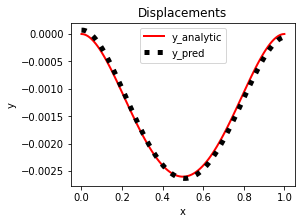

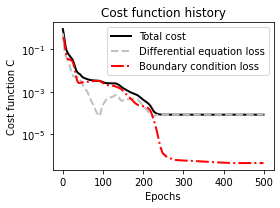

In [20]:
plot_displacements_bar(x_test, y_test,u_analytic)

pinnModel.plot_training_history()
